In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('./data/vihallu-train.csv')
df.head()

,id,context,prompt,response,label
0,9b1ea51d-d1ff-45ba-8cf1-6a91328e8600,"Vào những năm 1870, hai nhà điêu khắc Augustus...","Vào những năm 1960, nơi nào trở thành trung tâ...",Quảng trường Washington là trung tâm của thế h...,extrinsic
1,db7a89c6-2a6a-42af-beef-58e557ecc819,Cách mạng Tháng Mười đã biến một cuộc chiến tr...,Cách mạng Tháng Mười đã khởi xướng chủ nghĩa p...,Sai. Cách mạng Tháng Mười đã đánh bại chủ nghĩ...,no
2,10fca062-d343-4eca-8434-93c7a8aa5e0e,Vị trí địa lý nằm giữa phương Đông và Địa Trun...,Dựa trên việc Đế quốc Ottoman không bao giờ ki...,Nền ẩm thực của Thổ Nhĩ Kỳ được xây dựng từ gi...,extrinsic
3,ece8eb9e-d6bb-407a-a567-d9531861c603,"Hồ Quý Ly trước có tên là Lê Quý Ly (黎季犛), biể...",Đời cháu thứ 12 của Hồ Hưng Dật sống ở đâu?,"Đời cháu thứ 12 của Hồ Hưng Dật, là Hồ Liêm, s...",no
4,b613217f-df2a-491e-8326-25811a31eb09,"Năm 2007, Bồ Đào Nha có khoảng 332.137 người n...","Từ thập niên 1990, tại sao xuất hiện một vài l...",Mặc dù Bồ Đào Nha đã đóng cửa biên giới hoàn t...,intrinsic


In [8]:
len(df)

7000

label
intrinsic    2448
extrinsic    2307
no           2245
Name: count, dtype: int64


<Axes: xlabel='label'>

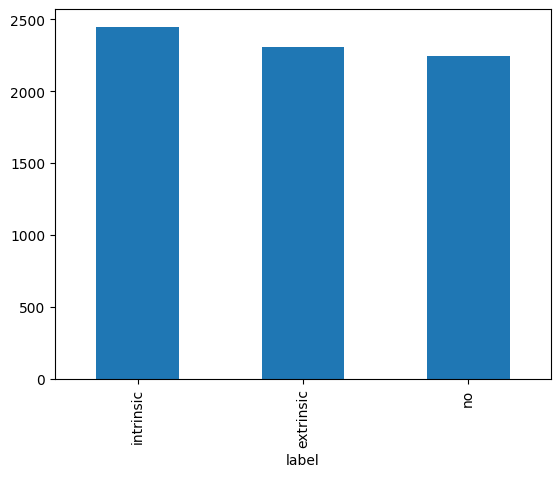

In [12]:
x = df['label'].value_counts()
print(x)
x.plot(kind='bar')

In [13]:
no_df = df[df['label'] == 'no']
intrinsic_df = df[df['label'] == 'intrinsic']
extrinsic_df = df[df['label'] == 'extrinsic']

dfs = [no_df, intrinsic_df, extrinsic_df]

In [18]:
PROMPT = """[ROLE] You are a Vietnamese hallucination classifier.
[GOAL] Determine whether the ANSWER contains hallucination relative to the CONTEXT and assign exactly one of 3 labels.

[CONTEXT]
{}

[QUESTION]
{}

[ANSWER]
{}

[GUIDELINES]
- Rely only on the [CONTEXT]; do not use outside knowledge or speculation.
- Label definitions:
  • class 1: no → Consistent with the context; does not introduce outside information.
  • class 2: intrinsic → Contradicts, distorts, or misinterprets information present in the context.
  • class 3: extrinsic → Adds information not present in the context (even if factually true elsewhere).
- Decision rules:
  • If partly correct but introduces content not in the context → extrinsic.
  • If it asserts something that conflicts with or corrupts the context → intrinsic.
  • If omissions are minor without being wrong or adding outside info → no.
- Prefer evidence by quoting or referencing the context; do not judge truth beyond the context.

Classification result:
The correct answer is: class {}"""

In [20]:
from typing import List
def build_training_prompts(df: pd.DataFrame) -> List[str]:
    texts = []
    for i in range(len(df)):
        context_ = df['context'].iloc[i]
        prompt_ = df['prompt'].iloc[i]
        response_ = df['response'].iloc[i]
        label_ = df['label'].iloc[i]
        texts.append(PROMPT.format(context_, prompt_, response_, label_))

    return texts

In [25]:
df['text'] = build_training_prompts(df)

In [27]:
%%capture
!mamba install cudatoolkit xformers bitsandbytes pytorch pytorch-cuda=11.8 \
    -c pytorch -c nvidia -c xformers -c conda-forge -y
!pip install "unsloth[kaggle] @ git+https://github.com/unslothai/unsloth.git"
!pip install bitsandbytes
!pip uninstall datasets -y
!pip install datasets

In [28]:
from unsloth import FastLanguageModel
NUM_CLASSES = 3
dtype = None
load_in_4bit = False

model_name = "unsloth/Qwen3-4B-Base"

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


Skipping import of cpp extensions due to incompatible torch version 2.9.0+cu128 for torchao version 0.13.0
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.8.0+cu128 with CUDA 1208 (you have 2.9.0+cu128)
    Python  3.9.23 (you have 3.12.3)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Switching to PyTorch attention since your Xformers is broken.

Unsloth: Xformers does not work in RTX 50X, Blackwell GPUs as of yet. Please build from source via
```
pip install ninja
pip install -v --no-build-isolation -U git+https://github.com/facebookresearch/xformers.git@main#egg=xformers
```

🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    load_in_4bit=load_in_4bit,
    dtype=dtype,
    # device_map = "balanced",
)

==((====))==  Unsloth 2025.10.6: Fast Qwen3 patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 5090. Num GPUs = 1. Max memory: 31.367 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
token_counts = [len(tokenizer.encode(x)) for x in df.text]

print("Min tokens:", min(token_counts))
print("Max tokens:", max(token_counts))
print("Avg tokens:", sum(token_counts)/len(token_counts))

plt.hist(token_counts, bins=30)
plt.xlabel("Số lượng tokens")
plt.ylabel("Số mẫu")
plt.title("Phân phối số token trong train_df.text")
plt.show()